In [1]:
#import cellxgene_census as cell_census
import anndata as ad
import umap

import pronto
import warnings
warnings.filterwarnings("ignore", category=pronto.warnings.ProntoWarning)


import pandas as pd
import numpy as np
from scipy import sparse
import copy
import time
import sys
import os
import pickle
from datetime import datetime

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim.lr_scheduler as lr_scheduler

from torcheval.metrics.functional import multilabel_accuracy

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score

import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style(style='whitegrid')
sns.set_context(context='notebook')
plt.rc('figure', autolayout=True)
plt.rc(
    'axes',
    labelweight='bold',
    labelsize='large',
    titleweight='bold',
    titlesize=9,
    linewidth=4
    )

%matplotlib inline

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cpu


## Plotting Functions

In [39]:
def plot_results(marginalization_dict,num_epochs,save_title=None):
    fig, ax = plt.subplots(4,2,figsize=(9,12))
    
    
    sns.lineplot(x=range(1,num_epochs+1),y=marginalization_dict['accuracy_train_leaf_hist'], 
                    ax = ax[0,0],color='lightcoral',label='Train')
    sns.lineplot(x=range(1,num_epochs+1),y=marginalization_dict['accuracy_val_leaf_hist'], 
                    ax = ax[0,0],color='mediumslateblue',label='Validation')
    
    sns.lineplot(x=range(1,num_epochs+1),y=marginalization_dict['accuracy_train_internal_hist'],
                   ax = ax[0,1],color='lightcoral',label='Train')
    sns.lineplot(x=range(1,num_epochs+1),y=marginalization_dict['accuracy_val_internal_hist'],
                   ax = ax[0,1],color='mediumslateblue',label='Validation')
    
    sns.lineplot(x=range(1,num_epochs+1),y=marginalization_dict['loss_train_hist'], 
                    ax = ax[1,0],color='lightcoral')
    sns.lineplot(x=range(1,num_epochs+1),y=marginalization_dict['loss_val_hist'], 
                    ax = ax[1,0],color='mediumslateblue')
    
    sns.lineplot(x=range(1,num_epochs+1),y=marginalization_dict['loss_train_leaf_hist'], 
                    ax = ax[1,1],color='lightcoral',marker='X',label='Train Leafs')
    sns.lineplot(x=range(1,num_epochs+1),y=marginalization_dict['loss_train_internal_hist'], 
                    ax = ax[1,1],color='lightcoral',marker='o',label='Train Internal')
    #sns.scatterplot(x=range(1,num_epochs+1),y=marginalization_dict['loss_train_internal_hist'], 
    #                ax = ax[1,0],color='lightcoral',marker='v',label='Train Internal')

    sns.lineplot(x=range(1,num_epochs+1),y=marginalization_dict['loss_val_leaf_hist'], 
                    ax = ax[2,0],color='mediumslateblue',marker='X',label='Val Leafs')
    sns.lineplot(x=range(1,num_epochs+1),y=marginalization_dict['loss_val_internal_hist'], 
                    ax = ax[2,0],color='mediumslateblue',marker='o',label='Val Internal')
    #sns.scatterplot(x=range(1,num_epochs+1),y=marginalization_dict['loss_val_internal_hist'], 
    #                ax = ax[1,1],color='mediumslateblue',marker='v',label='Val Internal')


    sns.lineplot(x=range(1,num_epochs+1),y=marginalization_dict['f1_score_train_leaf'], 
                    ax = ax[2,1],color='lightcoral',label='Train')
    sns.lineplot(x=range(1,num_epochs+1),y=marginalization_dict['f1_score_val_leaf'], 
                    ax = ax[2,1],color='mediumslateblue',label='Validation')

    sns.lineplot(x=range(1,num_epochs+1),y=marginalization_dict['f1_score_train_internal'], 
                    ax = ax[3,0],color='lightcoral',label='Train')
    sns.lineplot(x=range(1,num_epochs+1),y=marginalization_dict['f1_score_val_internal'], 
                    ax = ax[3,0],color='mediumslateblue',label='Validation')

    
    ax[0,0].set_xlabel('Epoch')
    ax[0,1].set_xlabel('Epoch')
    ax[1,0].set_xlabel('Epoch')
    ax[1,1].set_xlabel('Epoch')
    ax[2,0].set_xlabel('Epoch')
    ax[2,1].set_xlabel('Epoch')
    ax[3,0].set_xlabel('Epoch')


    ax[0,0].set_ylabel('Leaf Accuracy')
    ax[0,1].set_ylabel('Internal Accuracy')
    ax[1,0].set_ylabel('Total Loss')
    ax[1,1].set_ylabel('Training Loss')
    ax[2,0].set_ylabel('Validation Loss')
    ax[2,1].set_ylabel('Leaf F1 Score')
    ax[3,0].set_ylabel('Internal F1 Score')


    # set the boundary for the accuracy plots
    #ax[0,1].set_ylim((50,100))
    
    # turn off the axis for subplot 2,1
    ax[3,1].axis('off')
    
    if save_title:
        plt.savefig(save_title)



## Load the Saved Outputs from McCell_preprocessing

- X_train,X_val,y_train,y_val (do this only if we do manual batching. If we switch to DataLoader, we might not want to split the data. Come back to this)
- cell_parent_mask
- Mapping_dict
- Ontology_df
- Internal_values
- leaf_values


In [3]:
# define the date in yyyy-mm-dd format
date = '2024-02-22'

In [21]:
ontology_df_name = date + '_ontology_df.csv'
ontology_df = pd.read_csv(ontology_df_name,index_col=0)


mapping_dict_name = date + '_mapping_dict_df.csv'
mapping_dict_df = pd.read_csv(mapping_dict_name,index_col=0)
mapping_dict = mapping_dict_df.T.to_dict('list')
# the values are stored as a list. convert to single value
for key, value in mapping_dict.items():
    mapping_dict[key] = value[0]

leaf_values_name = date + '_leaf_values'
internal_values_name = date + '_internal_values'
with open(leaf_values_name,'rb') as fp:
    leaf_values = pickle.load(fp)
with open(internal_values_name,'rb') as fp:
    internal_values = pickle.load(fp)


X_train_name = date + '_X_train.pt'
X_val_name = date + '_X_val.pt'
y_train_name = date + '_y_train.pt'
y_val_name = date + '_y_val.pt'

X_train = torch.load(X_train_name)
X_val = torch.load(X_val_name)
y_train = torch.load(y_train_name)
y_val = torch.load(y_val_name)

cell_parent_mask_name = date + '_cell_parent_mask.pt'
cell_parent_mask = torch.load(cell_parent_mask_name)

## Build Neural Network Classifier

First, we need to select and define the input and output dimensions from the data. The number of neurons for the hidden nodes is defined manually.

In [31]:
# number of features (len of X cols)
# select the number of gene columns
input_dim = X_train.size(dim=1) #adata.X.shape[1] 

# number of neurons for hidden layers
hidden_layer_1 = 256
hidden_layer_2 = 128

# number of classes (unique of y)
output_dim = torch.unique(y_train[y_train >= 0]).size(dim=0) #labels['encoded_labels'].nunique()

print(input_dim,hidden_layer_1,hidden_layer_2,output_dim)

19966 256 128 52


In [32]:
class Network(nn.Module):
    def __init__(self):
        super(Network, self).__init__()
        self.linear1 = nn.Linear(input_dim,hidden_layer_1)
        self.linear2 = nn.Linear(hidden_layer_1,hidden_layer_2)
        self.linear3 = nn.Linear(hidden_layer_2,output_dim)
        self.bn1 = nn.BatchNorm1d(hidden_layer_1)
        self.bn2 = nn.BatchNorm1d(hidden_layer_2)
        
    def forward(self,x):
        x = self.linear1(x)
        x = self.bn1(x)
        x = F.relu(x)
        x = self.linear2(x)
        x = self.bn2(x)
        x = F.relu(x)
        x = self.linear3(x)
        x = F.softmax(x,dim=1)
        return x
    
    def get_last_layer(self,x):
        x = self.linear1(x)
        x = self.bn1(x)
        x = F.relu(x)
        x = self.linear2(x)
        x = self.bn2(x)
        x = F.relu(x)
        x = self.linear3(x)
        return x

## Functions for dealing with cell ontology and loss calculations

We'll need a few specific functions to process the predicted values with the structure of the Cell Ontology. We'll define these here. Full details of each function are found in each space. 

- output_probability_tensor: convolves the predicted classification outputs with the ontology hierarchy to get predicted normalized probabilities for all parent nodes
- target_probability_tensor: convolves the known target values with the ontology hierarchy to get target probabilities for all parent nodes
- build_mask_tensor_for_batch : builds a masking tensor from cell_parent_mask specific to the targets for each batch of data.

In [33]:
def output_probability_tensor(outputs,ontology_df):
    '''
    Function to convolve the predicted classification outputs with the ontology heirarchy to
    get predicted normalized probabilities for all parents. 
    Precursur to loss calculation
    
    Parameters
    ----------
    outputs : tensor
        PyTorch tensor of shape [a,b] where a = number of cells and b = number of target leafs
        This tensor is the result of the classification in the neural network
                
    ontology_df : pandas dataframe
        pandas dataframe where rows are parent labels and columns are leafs
        values indicate if parent node is an ancestor of leaf node


    Outputs
    -------
    sum_probability_tensor : tensor
        PyTorch tensor of shape [c,a] where c = number of cell ontology IDs and a = number of cells
        Each entry is the summed predicted probability for that cell ID

    '''
        
    # convert the dataframe to a pytorch tensor
    ontology_tensor = torch.FloatTensor(ontology_df.values)
    ontology_tensor = ontology_tensor.to(device)
        
    # convolve the ontology tensor with the predicted outputs
    # ontology tensor is shape ij, where i = parent IDs, j = probability for leaf IDs
    # output tensor is shape kj, where k = number of cells classified, j = probability for leaf IDs
    # probability tensor is shape ijk
    
    # if there is only a single column for the ontology, change shape to match expected value
    if len(ontology_tensor.shape) == 1:
        ontology_tensor = ontology_tensor.unsqueeze(1)    
    #print(ontology_tensor.shape)
    #print(outputs.shape)
    probability_tensor = torch.einsum('ij,kj->ijk',ontology_tensor,outputs)
    #print('prob_tensor', probability_tensor.shape)
    
    # sum across leafs to get the predicted probability, by cell, for each
    # parent 
    # sum_probability_tensor is shape ik, where i = parent IDs, k = number of cells
    sum_probability_tensor = torch.sum(probability_tensor,dim=1,dtype=float)
    
    ##sum_masked_probability_tensor = sum_probability_tensor * batch_masking_tensor
    #print('sum masked',sum_masked_probability_tensor.shape)
    #print('sum masked',sum_masked_probability_tensor.sum(dim=1))
    # ensure that the max value is 1 because of floating point issues
    # if we don't do this, we can run into errors with the binary cross entropy
    ##sum_masked_probability_tensor = torch.where(sum_masked_probability_tensor > 1, 1.0, sum_masked_probability_tensor )
    sum_probability_tensor = torch.where(sum_probability_tensor > 1, 1.0, sum_probability_tensor )

    return sum_probability_tensor


In [34]:
def build_mask_tensor_for_batch(cell_parent_mask,y_batch,min_encoded_value,max_encoded_value):
    '''
    For each batch, this function builds the correct masking tensor based on which
    values of the cell ontology we want to include given the target. It returns aa 
    
    Parameters
    ----------
    cell_parent_mask : tensor
        tensor of shape ik, where i = parent IDs and k = each cell type in the dataset
        binary tensor where 1 means for that cell type, that parent ID will be included
        in the internal loss calculation
        and 0 means for that cell type, that parent ID is excluded in the internal loss
        calculation
                
    y_batch : tensor
        tensor with encoded target values for current batch of data
        
    min_encoded_value : int
        the minimum encoded value from the full set of target values. Typically -9999
        
    max_encoded_value : int
        the maximum encoded value from the full set of target values. Depends on number
        of leaf targets in the dataset

    Outputs
    -------
    batch_masking_tensor : tensor
        PyTorch tensor of shape [c,a] where c = number of cell ontology IDs and a = number of cells
        Binary tensor to zero out probabilities we do not want
    
    '''
    # 1) from y_batch, we need to get the indices we'll use to select from cell_parent_mask
    #.   all the positive values are each, but we need to convert the negative values to
    #.   correspond with the (positive) index they would otherwise be. Then save to a tensor
    
    for value in y_batch:
        if value >= 0:
            new_value = value
        else:
            new_value = (value - min_encoded_value) + max_encoded_value + 1
        try:
            converted_y_batch = torch.cat((converted_y_batch,new_value.reshape(1)),dim=0)
        except:
            converted_y_batch = new_value.reshape(1)
    
    
    # 2) use the y_batch converted values to build a new tensor from cell_parent_mask
    #.    that is the mask we will use for this batch of values.
    #.    return this tensor

    cell_parent_mask = cell_parent_mask.to(device)
    batch_masking_tensor = torch.index_select(cell_parent_mask,1,converted_y_batch)
    #print(batch_masking_tensor.sum(dim=0))
    
    return(batch_masking_tensor)



In [35]:
def target_probability_tensor(target_values,ontology_df,mapping_dict):
    '''
    Function to convolve the known target values with the ontology heirarchy
    Precursur to loss calculation
    
    Parameters
    ----------
    target_values : tensor
        PyTorch tensor of shape [a] where a = number of cells
                
    ontology_df : pandas dataframe
        pandas dataframe where rows are parent labels and columns are leafs
        values indicate if parent node is an ancestor of leaf node

    mapping_dict : dictionary
        dictionary mapping the Cell Ontology IDs (keys) to the encoded values (values)
        Values >= 0 are leaf nodes
        Values < 0 are internal nodes

    Outputs
    -------
    target_tensor : tensor
        PyTorch tensor of shape [c,a] where c = number of cell ontology IDs and a = number of cells
        Each entry is the summed predicted probability for that cell ID

    '''
    
    # loop through target values, pick out corresponding column of ontology_df
    # append that to a tensor
    
    # invert the mapping dict so that we can select columns by CELL TYPE ID
    inv_mapping_dict = {v: k for k,v in mapping_dict.items()}

    for count, target_value in enumerate(target_values):
        # get the cell ID from the inverted mapping dictionary based on the encoded value
        target_cell_id = inv_mapping_dict[target_value.item()]
        
        # look up the correct column by the Cell ID. get those column values and convert
        # to a tensor
        sub_target_tensor = torch.tensor(ontology_df.loc[:,target_cell_id].values,dtype=float).reshape(-1,1)
        
        if count == 0 :
            target_tensor = sub_target_tensor
        else:
            # set requires_grad so that we can track
            target_tensor = torch.cat((target_tensor,sub_target_tensor),1).requires_grad_()
    #print('target tensor shape',target_tensor.shape)
    #print('batch_masking_tensor',batch_masking_tensor.shape)
    ###masked_target_tensor = target_tensor * batch_masking_tensor
    ##print('masked target tensor',masked_target_tensor.shape)
    
    target_tensor = target_tensor.to(device)
    ###masked_target_tensor = masked_target_tensor.to(device)
    
    
    return target_tensor


# Marginalization Classification 

- Based on Dahll, et al., Hierarchical Image Classification using Entailment Cone Embeddings, CVPR 202
- https://arxiv.org/pdf/2004.03459.pdf
- Thesis slides: https://ankitdhall.github.io/publication/learning-representations-for-images-with-hierarchical-labels/master_thesis.pdf
- First Author website: https://ankitdhall.github.io/project/learning-representations-for-images-with-hierarchical-labels/

Important Details:
- we use mini-batch learning, with the batch size set by the user
- we model each batch of data at once, then split into leaf and internal nodes, based on the values in y_batch
- we calculate the loss two different ways, then sum to get the total loss
- we calculate and save the loss, accuracy, and F1 score for metrics to review


In [36]:
def marginalization_classification_manual_batch(X_train,X_val,y_train,y_val,num_epochs,ontology_leaf_df, 
                                                batch_size,internal_values,mapping_dict,
                                               ontology_df, threshold, cell_parent_mask):
    '''
    Performs training and validation simultaneously to allow visualization of model performance 
    per epoch. Accounts for entire tree structure of the ontology by classifying to the leaf nodes, 
    propogating the probabilities across the ontology, and calculating the loss for both the leafs 
    and parent nodes. 
    
    Parameters
    ----------
    X_train : Tensor
        pytorch tensor of training values
    
    X_val : Tensor
        pytorch tensor of validation values
        
    y_train : Tensor
        pytorch tensor of training target values
        
    y_val : Tensor
        pytorch tensor of validation target values
    
    num_epochs : int
        integer specify the number of epochs
        
    ontology_leaf_df : pandas dataframe
        pandas dataframe where indices (rows) are all leaf and parent cell IDs from the portion of 
        the ontology being queried, and columns are onlys leafs in portion of ontology being queried. 
        Differs from ontology_df in that columns do not include any internal nodes.
        
        Dataframe is binary. For each parent node, element = 1 if parent node is an ancestor
        of corresponding leaf node.
    
    batch_size : int
        integer specificying the number of samples processed before the model
        is updated
        
    internal_values : list
        list of Cell Ontology IDs for internal nodes included in the dataset
        
    mapping_dict : dict
        dictionary mapping the Cell Ontology IDs (keys) to the encoded values (values)
        Values >= 0 are leaf nodes
        Values < 0 are internal nodes
    
    ontology_df : pandas dataframe
        pandas dataframe where indices (rows) are all leaf and parent cell IDs from the portion of 
        the ontology being queried, and columns are leafs and internal nodes in portion of ontology being 
        queried. 
        Differs from ontology_leaf_df in that columns include both leaf and internal node values
        
        Dataframe is binary. For each parent node, element = 1 if parent node is an ancestor
        of corresponding leaf node.
        
    threshold : float
        value between 0 and 1 to set for making predictions. If the predicted probability is
        equal to or greater than threshold, we consider that a true prediction
        
    cell_parent_mask : tensor
        tensor of shape ik, where i = parent IDs and k = each cell type in the dataset
        binary tensor where 1 means for that cell type, that parent ID will be included
        in the internal loss calculation
        and 0 means for that cell type, that parent ID is excluded in the internal loss
        calculation

        
    Returns
    -------    
    marginalization_dict : dictionary
        dictionary containing results from each epoch of the neural network
    
    Keys and Values include:
    
        accuracy_train_leaf_hist : list
            list containing accuracy for leaf values for the training set per epoch
            
        accuracy_train_internal_hist : list
            list containing accuracy for internal values for the trainig set per epoch
        
        loss_train_hist: list
            list containing total loss values for the training set per epoch
            
        loss_train_leaf_hist : list
            list containing loss values for leaf nodes for the training set per epoch
            
        loss_train_parents_hist : list
            list containing loss values for parent nodes for the training set per epoch
        
        loss_train_internal_hist : list
            list containing loss values for internal nodes for the training set per epoch
        
        accuracy_val_leaf_hist : list 
            list containing accuracy for leaf values for the validation set per epoch
        
        accuracy_val_internal_hist : list
            list containing accuracy for internal values for the validation set per epoch
        
        loss_val_hist : list
            list containing total loss values for the validation set per epoch
            
        loss_val_leaf_hist : list
            list containing loss values for leaf nodes for the validation set per epoch
            
        loss_val_parents_hist : list
            list containing loss values for parent nodes for the validation set per epoch
            
        loss_val_internal_hist : list
            list containing loss values for internal nodes for the validation set per epoch
        
        f1_score_train_leaf : list
            list containing Macro F1 score for leaf nodes for training set per epoch 
        
        f1_score_val_leaf : list
            list containing Macro F1 score for leaf nodes for validation set per epoch 
        
        best_output : tensor
            PyTorch tensor containing the predicted probabilites for the most accurate
            epoch
            
        best_state_dict : dictionary
            Pytorch state_dict that contains the parameters for the best fitting models
    '''
    # initialize variables for saving values
    accuracy_train_leaf_hist = []
    accuracy_train_internal_hist = []
    loss_train_leaf_hist = []
    loss_train_parents_hist = []
    loss_train_internal_hist = []
    loss_train_hist = []
    
    accuracy_val_leaf_hist = []
    accuracy_val_internal_hist = []
    loss_val_hist = []
    loss_val_leaf_hist = []
    loss_val_parents_hist = []
    loss_val_internal_hist = []
    
    f1_score_train_leaf = []
    f1_score_val_leaf = []
    
    f1_score_train_parent = []
    f1_score_val_parent = []

    best_accuracy = - np.inf
    best_weights = None
    
    # get the list of leaf labels
    leaf_label_list = [value for (key,value) in mapping_dict.items() if value >= 0]

    # get the min and max encoded values
    min_encoded_value = min(y_train).item()
    max_encoded_value = max(y_train).item()

    # initialize network
    clf = Network()
    clf.to(device)

    # define loss and optimizer
    # we use two different loss methods for the leafs and parents
    # use Cross Entory Loss for leafs, because those probabilities are normalized
    #     and it is thus a multi-class problem
    # Use BCELoss for the parents because this is a multi-label problem
    #     and the probabilities are normalized, so we don't need BCELossWithLogits
    # initialize the leaf loss here
    # because of how we weight the parent loss, we will have to initialize that
    # loss on each iteration because the weighting will change.
    criterion_leafs = nn.CrossEntropyLoss(reduction='mean')
    
    #criterion_parents = nn.BCELoss(reduction='mean')
    optimizer = torch.optim.Adam(clf.parameters(), lr=1e-3)#, amsgrad=True, eps=1e-5)
    #scheduler = lr_scheduler.LinearLR(optimizer, start_factor=1.0, end_factor=0.5, total_iters=5)
    scheduler = lr_scheduler.StepLR(optimizer, step_size=5,gamma=0.5)

    #start_epoch = time.time()
    for epoch in range(num_epochs):
        #print('on epoch', epoch)
        
        # TRAINING
        #print('Begin Training...')
        clf.train()
        
        running_train_loss = 0.0
        #correct_train = 0
        #y_length = 0
                
        # set up manual batches - from https://stackoverflow.com/questions/45113245/how-to-get-mini-batches-in-pytorch-in-a-clean-and-efficient-way
        permutation = torch.randperm(X_train.size()[0]).to(device)
        permutation_cpu = permutation.cpu() # we want the same permutations, but need one copy on the cpu

        #start = time.time()
        for i in range(0,X_train.size()[0], batch_size):
            #if (i/batch_size) % 10 == 0:
            #print('on batch', i/batch_size, 'running time', (time.time()-start))

            indices = permutation[i:i+batch_size]
            indices_cpu = permutation_cpu[i:i+batch_size]
            #X_batch, y_batch = X_train[indices], y_train[indices] # doesn't work for sparse tensors

            X_batch = torch.index_select(X_train,0,indices_cpu).to(device)

            y_batch = torch.index_select(y_train,0,indices)#.to(device)

            
            # check that tensors are on gpu. if on gpu, get_device returns 0, if on cpu, returns -1
            #print(X_batch.get_device())
            #print(y_batch.get_device())
            
            # set optimizer to zero grad to remove previous epoch gradients
            optimizer.zero_grad()
            
            # make predictions for this batch
            #if epoch == 0:
            #    outputs_train = clf_nosoftmax(X_batch.float()) # might need to change to X_train.float()
            #else:
            outputs_train = clf(X_batch.float()) # might need to change to X_train.float()
            
            ######
            # create mask to separate leaf and internal nodes
            ######
            output_train_leaf = outputs_train[y_batch >= 0]
            #print(output_train_leaf.shape)
            y_batch_leaf = y_batch[y_batch >= 0]
            #print(y_batch_leaf.shape)
            
            #output_train_internal = outputs_train[y_batch < 0]
            #y_batch_internal = y_batch[y_batch < 0]
            

            # calculate loss for just the leafs
            loss_train_leafs = criterion_leafs(output_train_leaf, y_batch_leaf)

            # get the masking tensor for this batch of cells
            # for calculating the internal loss
            # we initialize BCE loss every batch because the mask changes based on which cells are
            # included and ordered for this batch
            batch_train_masking_tensor = build_mask_tensor_for_batch(cell_parent_mask,y_batch,min_encoded_value,max_encoded_value)
            criterion_parents = nn.BCELoss(weight=batch_train_masking_tensor,reduction='mean')

            
            # calculate the loss for the parents of the cells that are leafs
            output_train_parent_prob = output_probability_tensor(outputs_train,ontology_leaf_df)
            target_train_parent_prob = target_probability_tensor(y_batch,ontology_df,mapping_dict)

            #print(output_train_parent_prob)
            #print('output_train_parent_prob',output_train_parent_prob.shape)
            #print(target_train_parent_prob)
            #print('target_train_parent_prob',target_train_parent_prob.shape)
            
            loss_train_parents = criterion_parents(output_train_parent_prob,target_train_parent_prob)

            #######
            # calculate the loss for the cells that are internal nodes
            ##### total_accuracy_cell, total_number_of_cells
            
            #loss_train_internal, batch_accuracy_internal, batch_numbers_internal = internal_node_loss(
            #                                        output_train_internal,y_batch_internal,
            #                                         internal_values,mapping_dict,ontology_df,
            #                                        ontology_leaf_df,criterion_parents,threshold)
            
            # sum the loss for both leafs and parents
            loss_train = loss_train_leafs + loss_train_parents #+ loss_train_internal

            # backward propagation
            loss_train.backward()

            # optimize
            optimizer.step()
             
            running_train_loss += loss_train.item()
           
            # save predictions
            _, train_leaf_pred_per_epoch = output_train_leaf.max(dim=1)

            # calculate accuracy for internal cells
            #####
            # need to update this with the weighting somehow!!!!
            #####
            train_batch_accuracy = multilabel_accuracy(output_train_parent_prob,target_train_parent_prob,
                                                      threshold=threshold,criteria='hamming')
            
            # save the number of cells for batch, for use in weighting when
            # determining the overall accuracy per epoch
            train_batch_number_of_cells = output_train_parent_prob.shape[1]
                        
            # check size of internal tensors. if only 1 internal cell
            # reshape and detach
            # else just detach
            
            ##if len(batch_accuracy_internal.size()) == 0:
            ##    batch_accuracy_internal_shaped = batch_accuracy_internal.detach().reshape(1)
            ##    batch_numbers_internal_shaped = batch_numbers_internal.detach().reshape(1)
            ##else:
            ##    batch_accuracy_internal_shaped = batch_accuracy_internal.detach()
            ##    batch_numbers_internal_shaped = batch_numbers_internal.detach()
                
            
            if i == 0:
                train_leaf_pred_total = train_leaf_pred_per_epoch.detach()
                y_train_leaf_total = y_batch_leaf.detach()
                train_batch_accuracy_internal = train_batch_accuracy.reshape(1)
                train_total_number_of_cells = torch.tensor(train_batch_number_of_cells).reshape(1)
                output_train_probabilities = output_train_leaf.detach()
                train_parent_pred_total = output_train_parent_prob.detach()
                train_parent_true_total = target_train_parent_prob.detach()
            else:
                train_leaf_pred_total = torch.cat((train_leaf_pred_total,train_leaf_pred_per_epoch.detach()),0)
                y_train_leaf_total = torch.cat((y_train_leaf_total,y_batch_leaf.detach()),0)
                train_batch_accuracy_internal = torch.cat((train_batch_accuracy_internal,train_batch_accuracy.reshape(1)),0)
                train_total_number_of_cells = torch.cat((train_total_number_of_cells,torch.tensor(train_batch_number_of_cells).reshape(1)),0)
                output_train_probabilities = torch.cat((output_train_probabilities,output_train_leaf.detach()),0)
                train_parent_pred_total = torch.cat((train_parent_pred_total,output_train_parent_prob.detach()),1)
                train_parent_true_total = torch.cat((train_parent_true_total,target_train_parent_prob.detach()),1)
                #print('train parent pred',train_parent_pred_total.shape)
                #print('train parent true',train_parent_true_total.shape)
                            
            # calculate total epoch accuracy for internal nodes
            #epoch_internal_accuracy = / train_numbers_internal.sum() * 100
            
            #correct_train += (train_pred_per_epoch == y_batch).sum().item()
            #y_length += len(y_batch)
            
            # calculate F1 score
            #f1_val_score_epoch = f1_score(train_pred_per_epoch.cpu(),y_batch.cpu(),labels=output_dim,average='weighted',zero_division=np.nan)

        scheduler.step()
        
        # save tensors
        #if epoch == 14:
        #    torch.save(output_train_probabilities, 'output_good_nosoftmax_1Dec.pt')
        #    torch.save(y_train_leaf_total, 'targets_good_nosoftmax_1Dec.pt')
        
        # save accuracy
        #_, train_pred = outputs_train.max(dim=1)
        #correct_train = (train_pred == y_train).sum().item()
        #accuracy_train_hist.append(correct_train / y_length * 100.)
        #print('acc train hist', accuracy_train_hist[-1])
        
        train_total_number_of_cells = train_total_number_of_cells.to(device)
        
        correct_train_leaf = (train_leaf_pred_total == y_train_leaf_total).sum().item()
        accuracy_train_leaf_hist.append(correct_train_leaf / train_leaf_pred_total.shape[0] * 100.)
                
        correct_train_internal = (train_batch_accuracy_internal * train_total_number_of_cells).sum()
        accuracy_train_internal = (correct_train_internal / train_total_number_of_cells.sum() * 100.).item()
        accuracy_train_internal_hist.append(accuracy_train_internal)
        
        #print('sample acc', acc_full)

        # save loss
        loss_train_hist.append(loss_train.item())
        loss_train_leaf_hist.append(loss_train_leafs.item())
        loss_train_parents_hist.append(loss_train_parents.item())
        ##loss_train_internal_hist.append(loss_train_internal.item())
        
        # save f1 score
        # use average = weighted to account for label imbalance
        # use zero_division = np.nan to exclude labels where all 
        #       predictions and labels are negative
        f1_train_leaf_score = f1_score(y_train_leaf_total.cpu(), train_leaf_pred_total.cpu(),
                                  labels=leaf_label_list,average='weighted',zero_division=np.nan)
        f1_score_train_leaf.append(f1_train_leaf_score)
        
        # for the F1 score for the internal nodes, we need to first turn the probabilities
        # into predictions using our threshold value
        train_parent_pred_total_thresholded = torch.where(train_parent_pred_total > threshold,1.0,0.0)
        
        f1_train_parent_score = f1_score(train_parent_true_total.cpu(),train_parent_pred_total_thresholded.cpu(),
                                        average='weighted',zero_division=np.nan)
        f1_score_train_parent.append(f1_train_parent_score)
        #torch.save(train_parent_true_total.cpu(),'train_parent_true_total_20Feb.pt')
        #torch.save(train_parent_pred_total_thresholded.cpu(),'train_parent_pred_total_thresholded_20Feb.pt')

        
        # set up validation
        correct_val = 0
        y_val_length = 0
        
        with torch.no_grad():
            clf.eval()
            
            # set up manual batches
            # we don't need to randomly permute the validation set, but
            # this will provide consistency with the above.
            # for simplicity, let's use the same batch size
            permutation_val = torch.randperm(X_val.size()[0]).to(device)
            #start_val = time.time()
            for i in range(0,X_val.size()[0],batch_size):
            
                indices_val = permutation_val[i:i+batch_size]
                
                X_val_batch = torch.index_select(X_val,0,indices_val)
                y_val_batch = torch.index_select(y_val,0,indices_val)
                
            
                # calculate output by running through the network
                outputs_val = clf(X_val_batch.float())
            
                ######
                # create mask to separate leaf and internal nodes
                ######
                output_val_leaf = outputs_val[y_val_batch >= 0]
                y_val_batch_leaf = y_val_batch[y_val_batch >= 0]

                #output_val_internal = outputs_val[y_val_batch < 0]
                #y_val_batch_internal = y_val_batch[y_val_batch < 0]
            
                # calculate loss for just the leafs
                loss_val_leafs = criterion_leafs(output_val_leaf, y_val_batch_leaf)
        
                # get the masking tensor for this batch of cells
                # for calculating the internal loss
                # we initialize BCE loss every batch because the mask changes based on which cells are
                # included and ordered for this batch
                batch_val_masking_tensor = build_mask_tensor_for_batch(cell_parent_mask,y_val_batch,min_encoded_value,max_encoded_value)
                criterion_parents = nn.BCELoss(weight=batch_val_masking_tensor,reduction='mean')
                
                # calculate the loss for the parents of the leafs
                output_val_parent_prob = output_probability_tensor(outputs_val,ontology_leaf_df)
                target_val_parent_prob = target_probability_tensor(y_val_batch,ontology_df,mapping_dict)
                
                loss_val_parents = criterion_parents(output_val_parent_prob,target_val_parent_prob)

                #######
                # calculate the loss for the cells that are internal nodes
                #####

                #loss_val_internal, batch_accuracy_internal_val, batch_numbers_internal_val = internal_node_loss(output_val_internal,
                #                                                y_val_batch_internal,
                #                                                internal_values,mapping_dict,ontology_df,ontology_leaf_df,
                #                                                criterion_parents,threshold)

                
                # sum the loss for both leafs and parents
                loss_val = loss_val_leafs + loss_val_parents #+ loss_val_internal
            
            
                # get the predictions
                __, predicted_leaf_val_per_epoch = output_val_leaf.max(dim=1)            

                # calculate accuracy for internal cells
                #####
                # need to update this with the weighting somehow!!!!
                #####
                val_batch_accuracy = multilabel_accuracy(output_val_parent_prob,target_val_parent_prob,
                                                          threshold=threshold,criteria='hamming')

                # save the number of cells for batch, for use in weighting when
                # determining the overall accuracy per epoch
                val_batch_number_of_cells = output_val_parent_prob.shape[1]

                
                # save accuracy
                #correct_val += (predicted_val_per_epoch == y_val_batch).sum().item()
                #y_val_length += len(y_val_batch)
                
                # check size of internal tensors. if only 1 internal cell
                # reshape and detach
                # else just detach
                            
                #if len(batch_accuracy_internal_val.size()) == 0:
                #    batch_accuracy_internal_val_shaped = batch_accuracy_internal_val.detach().reshape(1)
                #    batch_numbers_internal_val_shaped = batch_numbers_internal_val.detach().reshape(1)
                #else:
                #    batch_accuracy_internal_val_shaped = batch_accuracy_internal_val.detach()
                #    batch_numbers_internal_val_shaped = batch_numbers_internal_val.detach()
                                
                if i == 0:
                    val_leaf_pred_total = predicted_leaf_val_per_epoch.detach()
                    y_leaf_val_total = y_val_batch_leaf.detach()
                    val_batch_accuracy_internal = val_batch_accuracy.reshape(1)
                    val_total_number_of_cells = torch.tensor(val_batch_number_of_cells).reshape(1)
                    val_parent_pred_total = output_val_parent_prob.detach()
                    val_parent_true_total = target_val_parent_prob.detach()

                else:
                    val_leaf_pred_total = torch.cat((val_leaf_pred_total,predicted_leaf_val_per_epoch.detach()),0)
                    y_leaf_val_total = torch.cat((y_leaf_val_total,y_val_batch_leaf.detach()),0)
                    val_batch_accuracy_internal = torch.cat((val_batch_accuracy_internal,val_batch_accuracy.reshape(1)),0)
                    val_total_number_of_cells = torch.cat((val_total_number_of_cells,torch.tensor(val_batch_number_of_cells).reshape(1)),0)
                    val_parent_pred_total = torch.cat((val_parent_pred_total,output_val_parent_prob.detach()),1)
                    val_parent_true_total = torch.cat((val_parent_true_total,target_val_parent_prob.detach()),1)

            # save total accuracy
            #accuracy_val_hist.append(correct_val / y_val_length * 100.)
            
            val_total_number_of_cells = val_total_number_of_cells.to(device)
            
            correct_val_leaf = (val_leaf_pred_total == y_leaf_val_total).sum().item()
            accuracy_val_leaf_hist.append(correct_val_leaf / val_leaf_pred_total.shape[0] * 100.)

            correct_val_internal = (val_batch_accuracy_internal * val_total_number_of_cells).sum()
            accuracy_val_internal = (correct_val_internal / val_total_number_of_cells.sum() * 100.).item()
            accuracy_val_internal_hist.append(accuracy_val_internal)

            
            # save loss
            loss_val_hist.append(loss_val.item())
            loss_val_leaf_hist.append(loss_val_leafs.item())
            loss_val_parents_hist.append(loss_val_parents.item())
            #loss_val_internal_hist.append(loss_val_internal.item())
            
            # save f1 score
            # use average = weighted to account for label imbalance
            # use zero_division = np.nan to exclude labels where all 
            #       predictions and labels are negative
            f1_val_leaf_score = f1_score(y_leaf_val_total.cpu(),val_leaf_pred_total.cpu(),
                                    labels=leaf_label_list,average='weighted',zero_division=np.nan)
            f1_score_val_leaf.append(f1_val_leaf_score)

            
            # for the F1 score for the internal nodes, we need to first turn the probabilities
            # into predictions using our threshold value
            val_parent_pred_total_thresholded = torch.where(val_parent_pred_total > threshold,1.0,0.0)

            f1_val_parent_score = f1_score( val_parent_true_total.cpu(),val_parent_pred_total_thresholded.cpu(),
                                        average='weighted',zero_division=np.nan)
            f1_score_val_parent.append(f1_val_parent_score)
            #torch.save(val_parent_true_total.cpu(),'val_parent_true_total_20Feb.pt')
            #torch.save(val_parent_pred_total_thresholded.cpu(),'val_parent_pred_total_thresholded_20Feb.pt')

            
            # check if best model
            if accuracy_val_leaf_hist[-1] > best_accuracy:
                best_acc = accuracy_val_leaf_hist[-1]
                best_state_dict = copy.deepcopy(clf.state_dict())
                best_output = copy.deepcopy(outputs_val)
            
        if (epoch + 1) % 1 == 0 or epoch == 0:
            print(f'[{epoch + 1}] Training Accuracy: {accuracy_train_leaf_hist[-1]:.3f} Validation Accuracy: {accuracy_val_leaf_hist[-1]:.3f}')
            print(f'Train Loss: {loss_train.item():.4f} Validation Loss: {loss_val.item():.4f}')
            #print(f'Internal Loss: {loss_val_internal.item():.4f}')
            #print('learning rate:', optimizer.param_groups[0]["lr"])
        #end_epoch = time.time()
        #print('epoch timer', end_epoch-start_epoch)

    print(f'Best Validation Accuracy: {best_acc:.3f}')
    
    # build dictionary to return values
    marginalization_dict = {}
    marginalization_dict['accuracy_train_leaf_hist'] = accuracy_train_leaf_hist
    marginalization_dict['accuracy_train_internal_hist'] = accuracy_train_internal_hist
    
    marginalization_dict['loss_train_hist'] = loss_train_hist
    
    marginalization_dict['loss_train_leaf_hist'] = loss_train_leaf_hist
    marginalization_dict['loss_train_internal_hist'] = loss_train_parents_hist

    marginalization_dict['accuracy_val_leaf_hist'] = accuracy_val_leaf_hist
    marginalization_dict['accuracy_val_internal_hist'] = accuracy_val_internal_hist

    marginalization_dict['loss_val_hist'] = loss_val_hist

    marginalization_dict['loss_val_leaf_hist'] = loss_val_leaf_hist
    marginalization_dict['loss_val_internal_hist'] = loss_val_parents_hist
    
    marginalization_dict['f1_score_train_leaf'] = f1_score_train_leaf
    marginalization_dict['f1_score_val_leaf'] = f1_score_val_leaf
    
    marginalization_dict['f1_score_train_internal'] = f1_score_train_parent
    marginalization_dict['f1_score_val_internal'] = f1_score_val_parent

    marginalization_dict['best_output'] = best_output
    marginalization_dict['best_state_dict'] = best_state_dict


    return marginalization_dict


In [42]:
num_epochs = 2

number_of_leafs = len(leaf_values)
number_of_parents = len(internal_values)

print('There are', number_of_leafs, 'leafs and', number_of_parents, 'parents.')

batch_size = 8192 #8192 # 4096
print('Number of training batches is {:.2f}'.format(X_train.shape[0]/batch_size))
print('Number of validation batches is {:.2f}'.format(X_val.shape[0]/batch_size))

# create dataframe that only includes leaf nodes
ontology_leaf_df = ontology_df[leaf_values]


# set the prediction threshold for internal nodes
threshold = 0.8
print('Prediction threshold for internal nodes is', threshold)

start = time.time()

marginalization_dict = marginalization_classification_manual_batch(X_train,X_val,y_train,y_val,
                                                                   num_epochs, ontology_leaf_df, batch_size,
                                                                  internal_values,mapping_dict,
                                                                  ontology_df,threshold, cell_parent_mask)

end = time.time()

time_minutes = (end-start)/60.
time_hours = (end-start)/3600.

print(f'Run time for {num_epochs} epochs was {time_minutes:.2f} minutes ({time_hours:.2f} hours)')


There are 52 leafs and 16 parents.
Number of training batches is 4.61
Number of validation batches is 1.15
Prediction threshold for internal nodes is 0.8
[1] Training Accuracy: 39.245 Validation Accuracy: 54.521
Train Loss: 3.8718 Validation Loss: 3.8860
[2] Training Accuracy: 60.747 Validation Accuracy: 64.644
Train Loss: 3.7016 Validation Loss: 3.9548
Best Validation Accuracy: 64.644
Run time for 2 epochs was 1.88 minutes (0.03 hours)


## Save portions of the modeling and visualize results


In [40]:
# get today's date for saving information about this model
today = datetime.today().strftime('%Y-%m-%d')


In [ ]:
# save the model parameters to a file

#marginalization_dict['best_state_dict']

model_title = today + '_best_model'

torch.save(marginalization_dict['best_state_dict'],model_title)


In [ ]:
# save the loss/accuracy/f1 scores to a file

cols_to_save = ['accuracy_train_leaf_hist','loss_train_hist', 
                'loss_train_leaf_hist', 'loss_train_internal_hist', 
                'accuracy_val_leaf_hist', 
                'loss_val_hist', 'loss_val_leaf_hist', 'loss_val_internal_hist', 
                'f1_score_train_leaf', 'f1_score_val_leaf',
               'f1_score_train_internal','f1_score_val_internal']

results_dict = {key: marginalization_dict[key] for key in cols_to_save}

results_df = pd.DataFrame.from_dict(results_dict, orient='columns')

results_df.insert(0,'epoch',range(1,num_epochs+1))

results_title = today + '_results.csv'


results_df.to_csv(results_title,index=False)


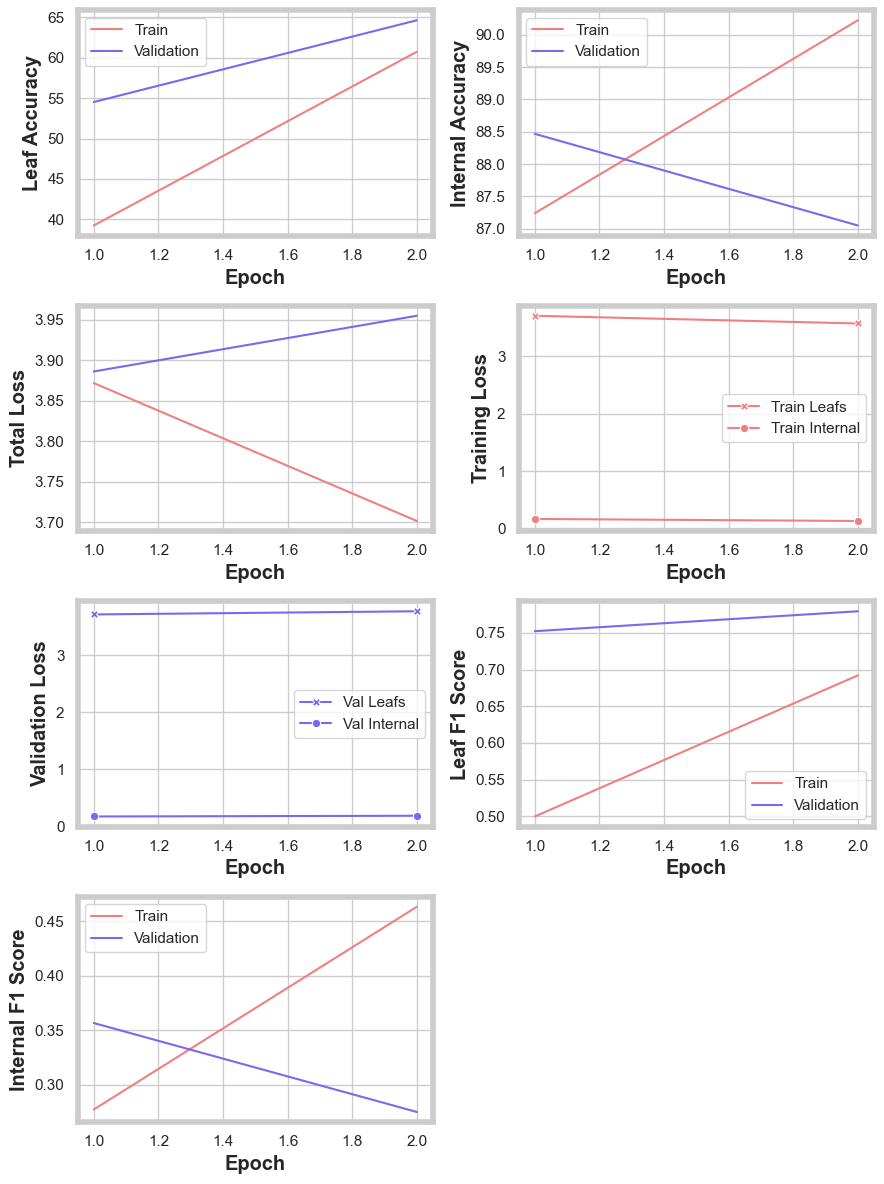

In [43]:
plot_title = today + '_results.png'


#plot_results(marginalization_dict,num_epochs,save_title='1Dec_results_hematopoietic.png')

plot_results(marginalization_dict,num_epochs)

